# Lendo dados experimentais


   vazão    h2    h1
0    0.0 -0.47 -0.06
1    0.0 -0.57 -0.06
2    0.0 -0.57 -0.16
3    0.0 -0.07 -0.16
4    0.0 -0.47 -0.06


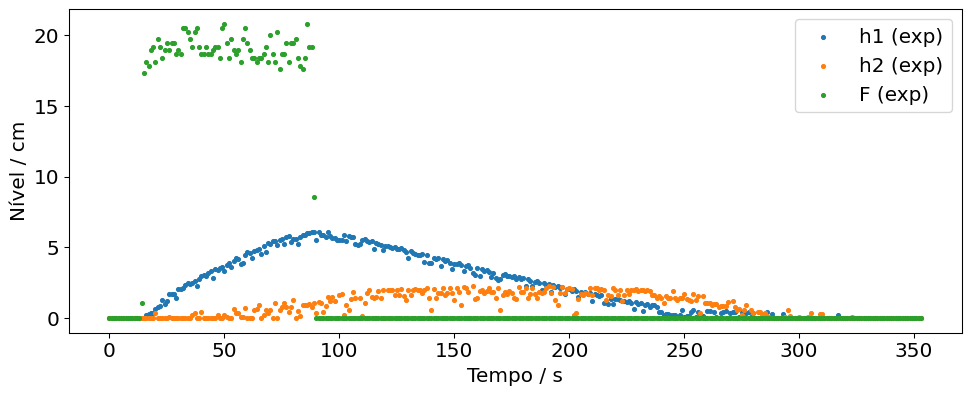

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.interpolate import interp1d

from plots import plot_tanks

exp_data = pd.read_csv("../exp-data.csv")

F_exp = exp_data["vazão"].to_numpy() * 2
h1_exp = torch.tensor(
    np.clip(exp_data["h1"].to_numpy(), 0.0, None), dtype=torch.float32
)
h2_exp = torch.tensor(
    np.clip(exp_data["h2"].to_numpy(), 0.0, None), dtype=torch.float32
)
t = np.arange(len(F_exp))

t_tensor = (
    torch.tensor(t, dtype=torch.float32)
    .unsqueeze(1)
    .clone()
    .detach()
    .requires_grad_(True)
)

F = interp1d(t, F_exp, kind="linear")

print(exp_data.head())

plot_tanks(t, [h1_exp, h2_exp, F_exp], ["h1 (exp)", "h2 (exp)", "F (exp)"], scatter=3)


# Definindo rede neural


In [2]:
from torch import nn

torch.manual_seed(42)


class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 1  # t
        hidden_size = 16
        output_size = 3  # h1, h2, cv2

        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        output = self.hidden_layer(((x * 2) / torch.max(t_tensor)) - 1)
        return output**2


# Definindo função Loss


In [3]:
import torch

from utils import dydx, mean_square


def edo_tanks(t, h1, h2, cv2):
    # Constantes
    a1 = 10 * 15  # cm^2
    a2 = torch.pi * (11 / 2) ** 2  # cm^2
    cv1 = 4.7150836

    # Tanks limits
    h1 = torch.where(h1 < 0.0, 0.0, h1)
    h2 = torch.where(h2 < 0.0, 0.0, h2)

    # Equations
    dh1dt = (torch.tensor(F(t.detach())) - cv1 * torch.sqrt(h1)) / a1
    dh2dt = (cv1 * torch.sqrt(h1) - cv2 * torch.sqrt(h2)) / a2
    return [dh1dt, dh2dt]


def loss_fn(model, t):
    # Loss das EDOs
    Y_pred = model(t)
    h1_pred, h2_pred, cv2_pred = Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2]

    dh1dt_pinn, dh2dt_pinn = dydx(t, h1_pred), dydx(t, h2_pred)
    dh1dt_edo, dh2dt_edo = edo_tanks(t, h1_pred, h2_pred, cv2_pred)

    loss_EDO1 = mean_square(dh1dt_pinn - dh1dt_edo)
    loss_EDO2 = mean_square(dh2dt_pinn - dh2dt_edo)

    # Loss dos dados
    loss_data_h1 = mean_square(h1_pred.squeeze() - h1_exp)
    loss_data_h2 = mean_square(h2_pred.squeeze() - h2_exp)

    # Loss total
    loss_total = loss_EDO1 + loss_EDO2 + loss_data_h1 * 0.01 + loss_data_h2 * 0.01

    return loss_total


# Testando métodos


## Adam


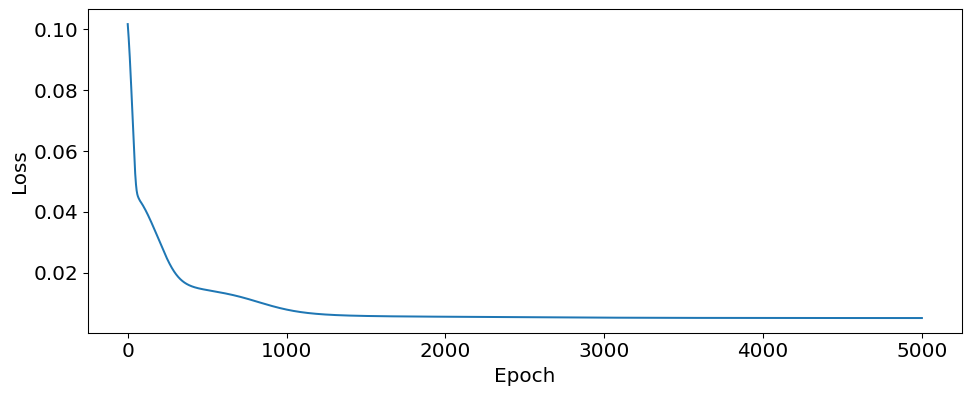

In [4]:
from plots import plot_loss

Adam_model = BaseModel()

optimizer = torch.optim.Adam(Adam_model.parameters(), lr=0.001)

# Listas vazias que usaremos para montar o gráfico do loss
loss_values = []
epoch_count = []


# O Loop de treinamento
for epoch in range(5000):
    # Coloca o modelo no modo de treinamento
    Adam_model.train()

    # Calcula o loss usando a nossa função loss.
    loss = loss_fn(Adam_model, t_tensor)

    # Ajusta os valores do modelo + detalhes de implementação do PyTorch. Não precisa se importar com isso, pelo menos por enquanto.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Guarda os valores de loss após cada época, isso vai nos ajudar a montar gráficos depois.
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())

plot_loss(loss_values, epoch_count)


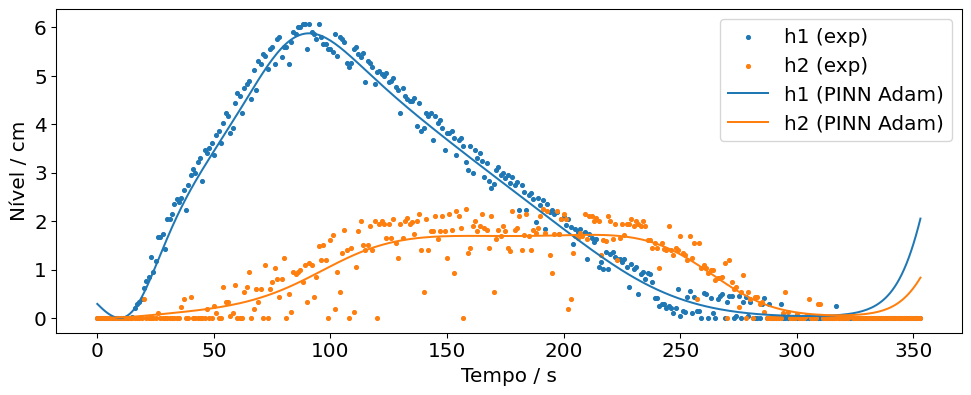

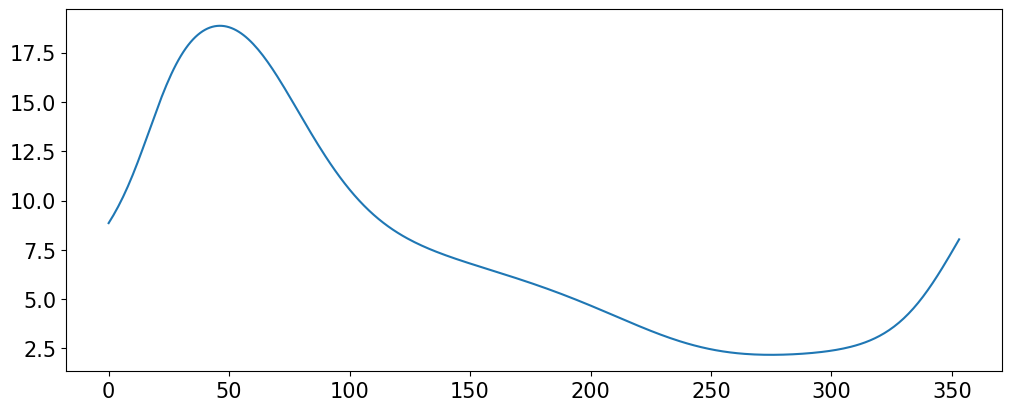

In [5]:
from matplotlib import pyplot as plt


@torch.inference_mode()
def test_model(model):
    y = model(t_tensor)
    return [y[:, 0], y[:, 1], y[:, 2]]


pinn_h1, pinn_h2, pinn_cv2 = test_model(Adam_model)

# Gráfico
plot_tanks(
    t,
    (h1_exp, h2_exp, pinn_h1, pinn_h2),
    ["h1 (exp)", "h2 (exp)", "h1 (PINN Adam)", "h2 (PINN Adam)"],
    scatter=2,
)

plt.figure(figsize=(10, 4), layout="constrained")
plt.plot(t, pinn_cv2, label="cv2 (PINN Adam)")
plt.show()
